In [225]:
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from scipy import integrate

Vamos a tomar núcleos de Bi 212 con $$T_{1/2}=60.55 \ \mathrm{min}$$ ahora al calcular el $\tau$ y $\Gamma$

In [226]:
tau=60.55/np.log(2)
gamma=1/tau



La probabilidad de decaer de un núcleo por minuto es de 0.011, por lo que vamos a considerar un $\Delta t$ de 10 minutos y tomando un rango de tiempo desde $t=0$ hasta $t_{f}=4\tau$

In [227]:
t=np.arange(0,4*tau,10)
tmed=((t+np.roll(t, shift=1))/2)[1:]

def P(t):
    return gamma*np.exp(-gamma*t)

pdf=np.array([integrate.quad(P,i,i+10)[0] for i in t[:-1]])
pdf=np.insert(pdf, 0, 0)
cdf=np.cumsum(pdf)



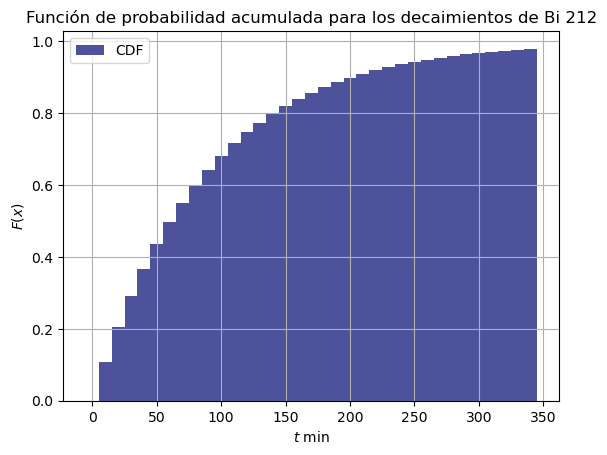

In [228]:
plt.bar(t,cdf, width=10, color="#4D529A", label=("CDF"))
plt.title("Función de probabilidad acumulada para los decaimientos de Bi 212")
plt.ylabel(r"$F(x)$")
plt.xlabel(r"$t$ min")
plt.grid()
plt.legend()
plt.show()

In [229]:
rn.seed(6121)
#Función para simular decaimientos de núcleos
def simul(N):
    histograma=np.zeros(N)
    for i in range(N):
        r = rn.random()
        if r <= cdf.max():
            for j in np.arange(1,len(cdf)):
                if r >= cdf[j-1] and r < cdf[j]:             
                    histograma[i]=tmed[j-1]
                    break
        else:
            continue
    no_cero = np.nonzero(histograma)
    histograma=histograma[no_cero]
    return histograma       #retorna lista con el minuto en que decayó cada núcleo

N=np.array([1e2,1e3,1e6,1e8])
s=[]
for n in N:
    s.append(simul(int(n)))   #simulamos para las diferentes cantidades de núcleos

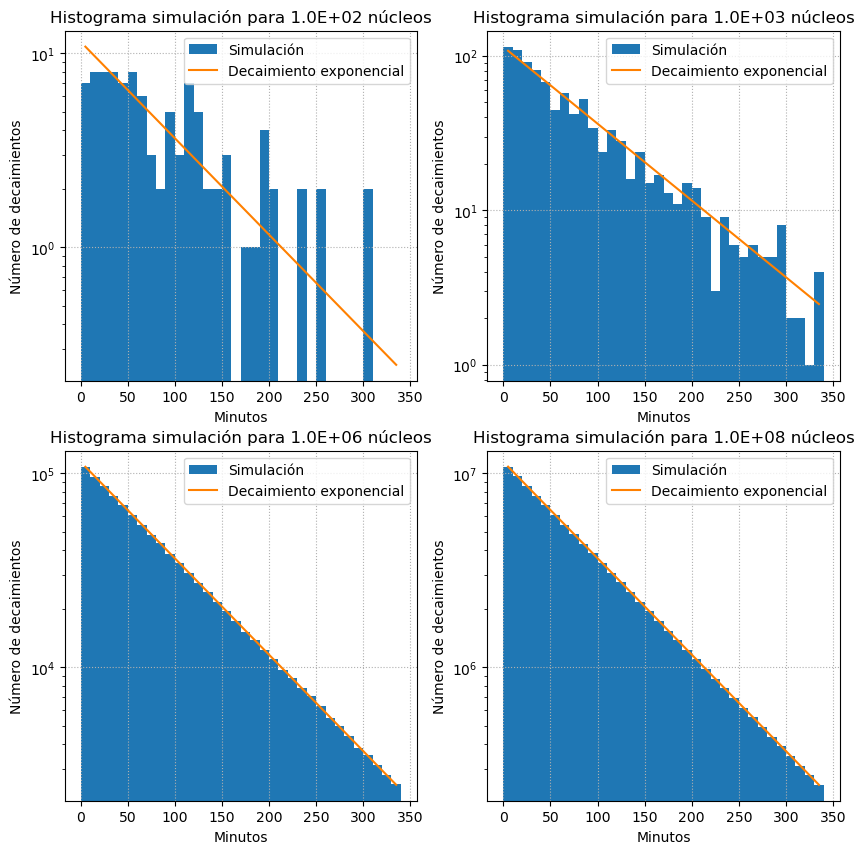

In [230]:
fig , ax = plt.subplots(2,2,figsize=(10,10))  #Graficacion

ax[0,0].hist(s[0],t,label=("Simulación"))
ax[0,0].plot(tmed,10*N[0]*P(tmed), color="#ff8000", label=("Decaimiento exponencial"))
ax[0,0].set_title(f"Histograma simulación para {N[0]:.1E} núcleos")
ax[0,0].set_ylabel("Número de decaimientos")
ax[0,0].set_xlabel("Minutos")
ax[0,0].legend()
ax[0,0].set_yscale("log")
ax[0,0].grid(linestyle=':')

ax[0,1].hist(s[1],t,label=("Simulación"))
ax[0,1].plot(tmed,10*N[1]*P(tmed) , color="#ff8000", label=("Decaimiento exponencial"))
ax[0,1].set_title(f"Histograma simulación para {N[1]:.1E} núcleos")
ax[0,1].set_ylabel("Número de decaimientos")
ax[0,1].set_xlabel("Minutos")
ax[0,1].legend()
ax[0,1].set_yscale("log")
ax[0,1].grid(linestyle=':')

ax[1,0].hist(s[2],t,label=("Simulación"))
ax[1,0].plot(tmed,10*N[2]*P(tmed) , color="#ff8000", label=("Decaimiento exponencial"))
ax[1,0].set_title(f"Histograma simulación para {N[2]:.1E} núcleos")
ax[1,0].set_ylabel("Número de decaimientos")
ax[1,0].set_xlabel("Minutos")
ax[1,0].legend()
ax[1,0].set_yscale("log")
ax[1,0].grid(linestyle=':')

ax[1,1].hist(s[3],t,label=("Simulación"))
ax[1,1].plot(tmed,10*N[3]*P(tmed) , color="#ff8000", label=("Decaimiento exponencial"))
ax[1,1].set_title(f"Histograma simulación para {N[3]:.1E} núcleos")
ax[1,1].set_ylabel("Número de decaimientos")
ax[1,1].set_xlabel("Minutos")
ax[1,1].legend()
ax[1,1].set_yscale("log")
ax[1,1].grid(linestyle=':')

plt.show()